<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/05_MNIST_Estimator_Tensorboard_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please run this notebook on a GPU backend. Porting the model from Estimator to TPUEstimator is needed for it to work on TPU.

## MNIST with Tensorboard, using the Estimator API

Fun with handwritten digits and tensorboard.

This notebook will show you how to follow your training and validation curves in Tensorboard and what you can do to address the issues you see there.

### Imports

In [0]:
import os, re, math, json, shutil, pprint, datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.12.0


### Parameters

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
BUCKET = '' #@param {type:"string"}

assert re.search(r'gs://.+', BUCKET), 'You need a GCS bucket for your Tensorboard logs. Head to http://console.cloud.google.com/storage and create one.'

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Colab-only auth

In [0]:
# backend identification
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence

# Auth on Colab
# Little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
  t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
  
  # Run once, get one batch. Session.run returns numpy results
  with tf.Session() as ses:
    (validation_digits, validation_labels,
     training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [0]:
def read_label(tf_bytestring):
    label = tf.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(10)  # fetch next batches while training on the current one
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# In Estimator, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

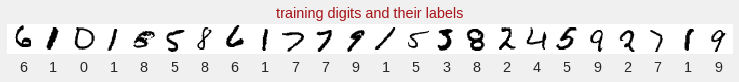

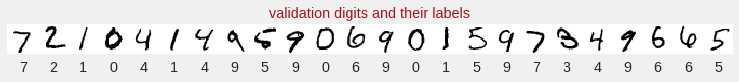

In [0]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Estimator model [WORK REQUIRED]
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [0]:
def model_fn(features, labels, mode):
  
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  x = features
  y = tf.reshape(x, [-1, 28, 28, 1])  # input images are 28x28 pixels, greyscale (-1 is for variable batch size)

  ###
  # YOUR LAYERS HERE
  # LAYERS YOU CAN TRY:
  # y = tf.layers.Conv2D(filters=6, kernel_size=3, padding='same', strides=1, activation="relu")(y)
  # y = tf.layers.Dense(200, activation="relu")(y)
  # y = tf.layers.MaxPooling2D(pool_size=2)(y)
  # y = tf.layers.Dropout(0.3)(y, training=is_training)
  #
  y = tf.layers.Flatten()(y)
  y = tf.layers.Dense(200, activation='relu')(y)
  ###
  
  logits = tf.layers.Dense(10)(y)
  predictions = tf.nn.softmax(logits)
  classes = tf.math.argmax(predictions, axis=-1)
  
  if (mode != tf.estimator.ModeKeys.PREDICT):
    loss = tf.losses.softmax_cross_entropy(labels, logits)

    step = tf.train.get_or_create_global_step()
    
    ###
    # YOUR LEARNING RATE SCHEDULLE HERE
    # 
    lr = 0.005
    # lr = 0.0001 + tf.train.exponential_decay(0.005, step, 3000, 1/math.e)
    # tf.summary.scalar("learn_rate", lr) # you can visualize it in Tensorboard
    ###

    optimizer = tf.train.AdamOptimizer(lr)
    
    # little wrinkle: batch norm uses running averages which need updating after each batch. create_train_op does it, optimizer.minimize does not.
    train_op = tf.contrib.training.create_train_op(loss, optimizer)
    #train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())

    metrics = {'accuracy': tf.metrics.accuracy(classes, tf.math.argmax(labels, axis=-1))}
  else:
    loss = train_op = metrics = None  # None of these can be computed in prediction mode because labels are not available
  
  return tf.estimator.EstimatorSpec(
    mode=mode,
    predictions={"predictions": predictions, "classes": classes},  # name these fields as you like
    loss=loss,
    train_op=train_op,
    eval_metric_ops=metrics
  )
# little wrinkle: tf.keras.layers can normally be used in an Estimator but tf.keras.layers.BatchNormalization does not work
# in an Estimator environment. Using TF layers everywhere for consistency. tf.layers and tf.ketas.layers are carbon copies of each other.

In [0]:
# Called once when the model is saved. This function produces a Tensorflow
# graph of operations that will be prepended to your model graph. When
# your model is deployed as a REST API, the API receives data in JSON format,
# parses it into Tensors, then sends the tensors to the input graph generated by
# this function. The graph can transform the data so it can be sent into your
# model input_fn. You can do anything you want here as long as you do it with
# tf.* functions that produce a graph of operations.
def serving_input_fn():
    # placeholder for the data received by the API (already parsed, no JSON decoding necessary,
    # but the JSON must contain one or multiple 'image' key(s) with 28x28 greyscale images  as content.)
    inputs = {"serving_input": tf.placeholder(tf.float32, [None, 28, 28])}  # the shape of this dict should match the shape of your JSON
    features = inputs['serving_input']  # no transformation needed
    return tf.estimator.export.TensorServingInputReceiver(features, inputs)  # features are the features needed by your model_fn
    # Return a ServingInputReceiver if your features are a dictionary of Tensors, TensorServingInputReceiver if they are a straight Tensor

### Train and validate the model

In [0]:
EPOCHS = 3
steps_per_epoch = 60000 // BATCH_SIZE  # 60,000 images in training dataset
MODEL_EXPORT_NAME = "mnist"  # name for exporting saved model

tf_logging.set_verbosity(tf_logging.INFO)
now = datetime.datetime.now() # create a model dir for each run
MODEL_DIR = BUCKET+"/mnistjobs/job" + "-{}-{:02d}-{:02d}-{:02d}:{:02d}:{:02d}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)

training_config = tf.estimator.RunConfig(model_dir=MODEL_DIR, save_summary_steps=30, save_checkpoints_steps=steps_per_epoch, log_step_count_steps=steps_per_epoch/4)
export_latest = tf.estimator.LatestExporter(MODEL_EXPORT_NAME, serving_input_receiver_fn=serving_input_fn)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=training_config)

train_spec = tf.estimator.TrainSpec(training_input_fn, max_steps=EPOCHS*steps_per_epoch)
eval_spec = tf.estimator.EvalSpec(validation_input_fn, steps=1, exporters=export_latest, throttle_secs=0) # no eval throttling: evaluates after each checkpoint

final_metrics = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
tf_logging.set_verbosity(tf_logging.WARN)
print(final_metrics)

### Visualize predictions

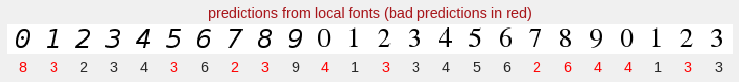

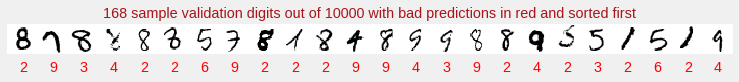

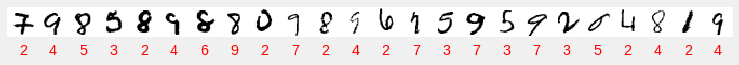

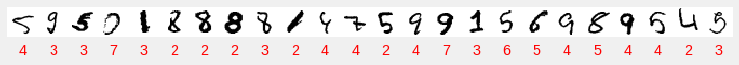

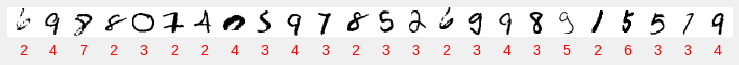

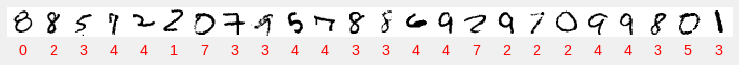

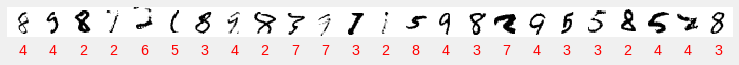

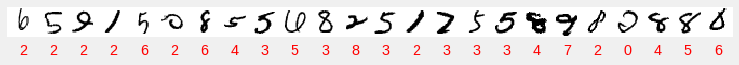

In [0]:
# recognize digits from local fonts
predictions = estimator.predict(lambda:  tf.data.Dataset.from_tensor_slices(font_digits).batch(N),
                                  yield_single_examples=False)  # the returned value is a generator that will yield one batch of predictions per next() call
predicted_font_classes = next(predictions)['classes']
display_digits(font_digits, predicted_font_classes, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
predictions = estimator.predict(validation_input_fn,
                                    yield_single_examples=False)  # the returned value is a generator that will yield one batch of predictions per next() call
predicted_labels = next(predictions)['classes']
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Configuration

In [0]:
PROJECT = "" #@param {type:"string"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "estimator_mnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'

export_path = os.path.join(MODEL_DIR, 'export', MODEL_EXPORT_NAME)
last_export = sorted(tf.gfile.ListDirectory(export_path))[-1]
export_path = os.path.join(export_path, last_export)
print('Saved model directory found: ', export_path)

### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [0]:
# Create the model
if NEW_MODEL:
  !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [0]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [0]:
# prepare digits to send to online prediction endpoint
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" because that is what you defined in your serving_input_fn: {"serving_input": tf.placeholder(tf.float32, [None, 28, 28])}
    f.write(data+'\n')

In [0]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}

predictions = np.array([int(p.split('[')[0]) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
display_top_unrecognized(digits, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
